# Implementation of the algorithm in the paper "Classically verifiable quantum advantage from a computational Bell test"

In this notebook, we implement the algorithm presented in the paper <a href="https://www.nature.com/articles/s41567-022-01643-7"> Classically verifiable quantum advantage from a computational Bell test</a> authored by **Gregory D. Kahanamoku-Meyer, Soonwon Choi, Umesh V. Vazirani, and Norman Y. Yao**. The paper discusses a novel interactive protocol designed to demonstrate quantum computational advantage, which is verifiable using classical means. The protocol utilizes cryptographic tools known as trapdoor claw-free functions (TCFs), specifically focusing on functions derived from the Rabin cryptosystem and the Diffie-Hellman problem.

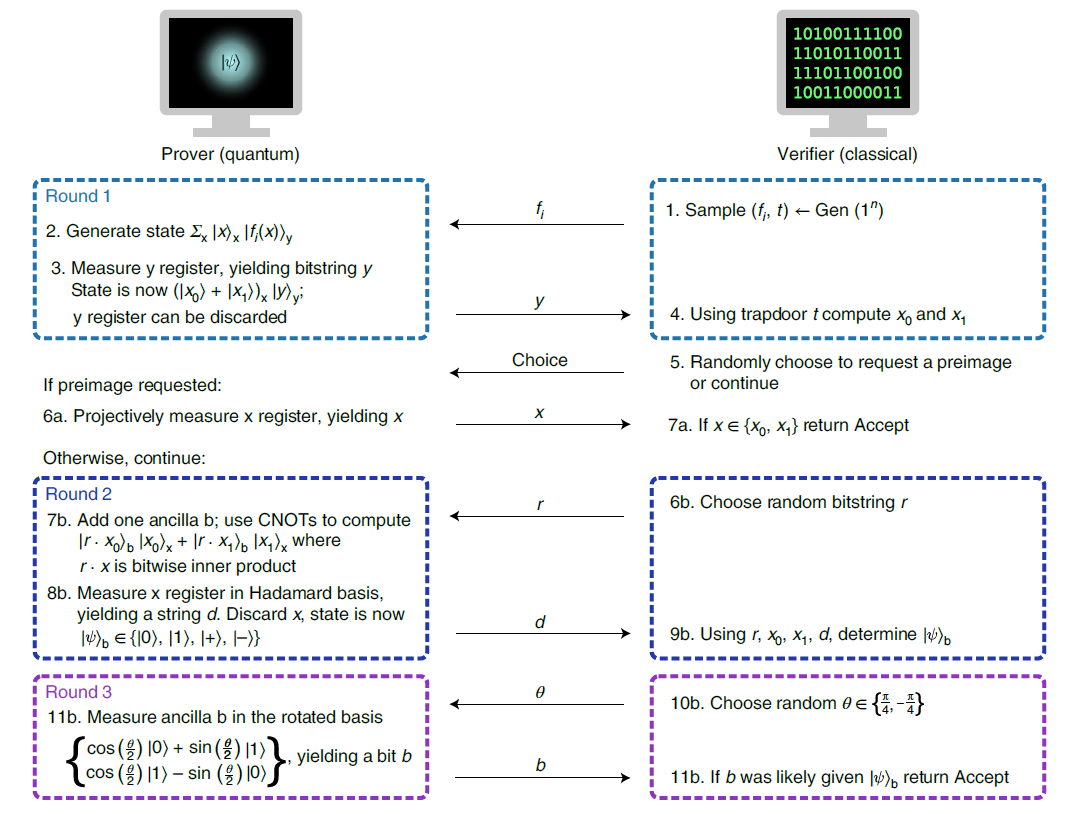

**Figure:** Flow diagram of the algorithm in the paper Kahanamoku-Meyer et al (2022).

This paper analyses a quantum advantage protocol that consists of three rounds of interaction between the quantum prover and classical verifier. The algorithm centers around a trapdoor claw free (TCF) 2 to 1 function $f$. The claw-free property of the function $f$ implies that it is difficult to find a pair $(x_0,x_1)$ such that $f(x_0)$ = $f(x_1)$, whereas being trapdoor implies the existence of an information $t$ that leads to an efficient computation of the preimages. 

In this case, the classical verifier possesses the trapdoor information $t$ and sends an instance of a 2-to-1 function $f$ to the prover. Upon receiving that, the  quantum prover generates the superposition $\sum_i |x_i\rangle |f(x_i)\rangle$ and then measures the right-hand register (the y register). Thus, the superposition collapses to a state $(|x_0 \rangle + |x_1 \rangle) |f(x_0) = f(x_1)\rangle.$ The prover then sends the value $y$ = $f(x_0)$ = $f(x_1)$ to the verifier. The verifier then uses the trapdoor $t$ to compute $x_0$ and $x_1.$


The verifier then either chooses to ask for a preimage or proceeds to rounds 2 and 3. In the first case, the prover collapses the left-hand register (the x register) to obtain a preimage, and then sends it to the verifier. If it agrees with one of the preimage computed by the verifier, the verifier accepts. The rate of acceptance in this case is 100%. If the protocol proceeds to round two, the verifier sends a random bitstring $r$ to the prover. The prover, in turn, generates the superposition $|r.x_0 \rangle |x_0 \rangle + |r.x_1 \rangle |x_1 \rangle$ and measures the x register in the Hadamard basis. The output bitstring $d$ is sent to the verifier. After this measurement, the state on the left-hand register of round 2 (the b register) is $(-1)^{d.x_0}|x_0\rangle + (-1)^{d.x_1}|x_1\rangle$.   

The last round is an implementation of the CHSH game in this context. The verifier requests measurements in a basis which is a rotation of the Z axis by $\pi/4$ or $-\pi/4$ around the Y axis. Since this basis can't be perpendicular to the state above, one of the outcomes is more likely after measurement in this basis. The verifier accepts if the more likely option is measured. As in the CHSH game, the probability of acceptance is $\cos^2(\pi/8) \sim 0.85$.

In [1]:
# import all the necessary packages
from classiq import *
from classiq.execution import ExecutionPreferences
import random
import numpy as np


### Choosing N

In this notebook, the idea is to implement the algorithm for the Trapdoor Claw-Free (TCF) function $x^2$ mod $N$. Roughly, a TCF function means a function having the property that finding pre-images is classically very hard; however, having trapdoor information available to a verifier makes it incredibly easy to compute the pre-images. For a function of this type to be a TCF, the number $N$ needs to be of a particular form; for example, it could be the product of two distinct primes as in the Rabin cryptosystem (see the paper for more details). For such an $N$, for each non-zero entry (y-values) in the range, there are exactly 2 pre-images (x-values $x_0$ and $x_1$) in the domain. Having exactly two pre-images for each y-value is one of the primary requirements for round 1 of the algorithm.

The number $N$ (as in the Rabin cryptosystem) must be very large for it to be considered a TCF function. With larger $N$, we need more qubits in our circuits. However, there is a **limitation of 25 qubits** in the Classiq simulators that we are using in our implementation. As we need the computation of $x$ and $x^2$, the value of $x$ can be a number requiring at most 8 qubits (in this case, the circuit will have 8 qubits for $x$ and 16 qubits for $x^2$, totaling to 24 qubits). Due to this reason, the actual implementation of the algorithm is limited. However, we note that after round 1 is done, the TCF function is not used anywhere else for further interactions. After round 1, the information we need to continue with are the two values $x_0$ and $x_1$ only. That is why in round 1, we simply choose to use values of $N$ less than $2^8 = 256$ such that each of the non-zero y-values has exactly two pre-images. However, all the functions used for the function `quantum_prover()` will remain exactly the same for any $N$ that actually satisfies the TCF condition, provided we have enough qubits available in the simulator/hardware.


Here's a list of all numbers between 3 and 255 that has the property that each y-values has exactly 2 pre-images.

In [15]:
def check(N: int):          #function to check if each non-zero y-values has exactly two pre-images for the function x^2 mod N
    x = [i for i in range(N)]
    y = [i**2 % N for i in range(N)]

    flag = True
    for yval in list(set(y))[1:]:
        xval = [x[index] for index, value in enumerate(y) if value == yval]
        if len(xval) != 2:
            flag = False
            break
    return(flag)

relevant_N = []

for i in range(2,256,1):
   if check(i) == True:
      relevant_N.append(i) 
print(relevant_N)

[3, 4, 5, 7, 9, 11, 13, 17, 19, 23, 25, 29, 31, 37, 41, 43, 47, 49, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 121, 127, 131, 137, 139, 149, 151, 157, 163, 167, 169, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233, 239, 241, 251]


Since we are not capable of choosing large enough $N$ to implement a TCF function anyway and we are using quantum simulators rather than quantum hardware, we shall try to use small $N$ to get better runtime of our algorithm. We select a few from the above list `relevant_N`.

In [16]:
# the random N generator (a helper function to the classical verifier)
def classical_verifier_N_generator():
    choices = [5, 7, 9, 11, 13, 17, 19, 23, 25, 29, 41, 53, 97, 121, 173, 241]
    return random.choice(choices)

In the case of a TCF function, the function `classical_verifier_round1()` would use the trapdoor information to verify whether the prover had provided a correct pre-image and further compute the other pre-image (not provided by the prover) for use in round 2 (as an input for `classical_verifier_round2()`). However, as we are using much smaller values of $N$, we have kept the function `classical_verifier_round1()` as simple as possible that only checks whether $x^2 $ mod $N$ is equal to $y$. While implementing this for a large $N$ in a suitable quantum hardware, we need to modify this function slightly to make use of the trapdoor information. 

In [6]:
# classical verifier round 1 (a helper function to the classical verifier)
def classical_verifier_round1(N: int, y: str, x: str):    #returns True only if x % N == y.
    flag = False
    if int(x,2)**2 % N == int(y,2):
        flag = True
    return flag 

After round 1 is complete, if the verifier decides to continue to round 2, it will have information about $x_0, x_1$, the random bitstring $r$ that it provided to the prover, and the bitstring $d$ that the prover provided to the verifier. The helper function `classical_verifier_round2()` takes these as inputs and computes the state $\ket{\psi}$ that the b register will be in after round 2. Theoretically, the b register will be in the state $\ket{\psi} = (-1)^{d.x_0}\ket{r.x_0} + (-1)^{d.x_1}\ket{r.x_1}$.

In [7]:
# classical verifier round 2 (a helper function to the classical verifier)
def classical_verifier_round2(r: str, d: str, x_0: str, x_1: str):       
    #returns the state |psi> in register b after the x-register collapses in round 2

    if len(r) == len(d) == len(x_0) == len(x_1):
        x0arr = np.array([int(s,2) for s in x_0])       #convert the bitstrings to numpy arrays
        x1arr = np.array([int(s,2) for s in x_1]) 
        d_arr = np.array([int(s,2) for s in d]) 
        r_arr = np.array([int(s,2) for s in r])  

        dx0 = np.dot(x0arr,d_arr) % 2           #compute the dot products mod 2
        dx1 = np.dot(x1arr,d_arr) % 2

        rx0 = np.dot(x0arr,r_arr) % 2
        rx1 = np.dot(x1arr,r_arr) % 2

        # final state is (-1)^dx0\ket{rx0} + (-1)^dx1\ket{rx1} 
        if rx0 == rx1 == 0:
            psi = np.array([1, 0])
        elif rx0 == rx1 == 1:
            psi = np.array([0,1])
        else:
            if dx0 == dx1:
                psi = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
            else:
                psi = np.array([1/np.sqrt(2), - 1/np.sqrt(2)])
        return psi     #returns the array of the statevector
    else:
        print("Error. The lengths of all the bitstrings must be the same.")


Using the state $\ket{\psi}$ from `classical_verifier_round2()` and the random angle $\theta$ that the verifier provided to the prover, the helper function `classical_verifier_round3()` computes the more likely bit that we get after we measure the b register in the rotated basis.

In [8]:
# classical verifier 3 (a helper function to the classical verifier)
def classical_verifier_round3(psi, theta):      #returns the more likely bit after we measure b register in the rotated basis in round 3
    theta = -theta
    if len(psi) == 2:
        RY_theta = np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])
        result_vec = np.matmul(RY_theta, psi)
        if result_vec[0]**2 > result_vec[1]**2:
            more_likely = 0
        else:
            more_likely = 1
        return more_likely
    else:
        print("Error. The state psi has to be a 1-qubit state.")

We use the following functions to generate the various random choices the verifier needs to make in order to conduct the whole interactive protocol.

In [9]:
# random choice generating functions for the classical verifier to send as input to the quantum prover

def classical_verifier_decision():  # returns True if the classical verifier chooses to ask for the value x
                                    # and ends the protocol in round 1
    return random.choice([True, False])


def classical_verifier_get_r(n):       # generates a random bitstring of size n
    return "".join(random.choice(['0','1']) for i in range(n))

def classical_verifier_get_theta():    # chooses a random theta from the set {pi/4, -pi/4}
    return random.choice([np.pi/4, -np.pi/4])

## Implementation of the quantum prover

The function `quantum_prover()` implements all the rounds involved in the 3 rounds of the prover.

### Description of the inputs:

- The integer for `N` to implement the function $x^2$ mod $N$.

### Break-down of the function `quantum_prover()`:

- We immediately compute `n` which is the least number of qubits needed to represent `N`.

- **Round 1:** The algorithm in the paper dictates that the verifier provides $N$ and asks for a y-value. The quantum prover provides the y-value by measuring the y register. Then if the verifier decides to end the protocol in round 1, the prover provides a x-value by measuring the x register. However, as of now, in the Classiq Qmod language documentaion, i) we don't have the implementation of mod $N$ for $N$ which is not a power of 2 and ii) we have not found an exact function to perform measurement of a particular register. We work around the first problem by simply preparing the registers x and z with the state $\sum_{x}\ket{x}\ket{x^2}$ and post-processing on z values after execution to get the y-values. We work around the second problem by measuring simply both the registers a high enough number of shots to get each bitstrings $x \in \{0,1\}^n$ and finally choosing a random bitstring `y_val` from the y-values in the array `collapsed_states_y` (after removing some unnecessary bitstrings, see the comments on the code) as if the quantum register y collapsed to this state when we measured the y register. We extract the x-values in the array `x_vals` that were present along with `y_val` in the original array of `collapsed_states`, then these x-values are nothing but the pre-images of `y_val`. The array `x_vals` contains exactly two values $x_0$ and $x_1$ due to the way we chose $N$. These two processes simulated the following:
    - measuring the y register that collapsed to `y_val`,
    - the x register can be prepared again in the state $\ket{x_0} + \ket{x_1}$ for further rounds in case the verifier decides to go for it.
- **Verifier chooses to terminate at round 1**: The verifier sends its decision using the function `classical_verifier_decision()` to the quantum prover. If the decision is `True`, the prover returns the values `y_val` and a random value from the array `x_vals` (to simulate the action of the x register collapsing to that particular state).

- **Round 2:** When the variable `decision` is `False`, we go to the round 2. Here, we again create a quantum program with two registers x and b. We use the values $x_0$ and $x_1$ from round 1 to prepare the x register in the state $\ket{x_0} + \ket{x_1}$ (**this simulates the idea that the x register was not collapsed in round 1 and that we are using the same register for round 2 and round 3**). At this point, we simulate the action of the verifier providing a random bitstring `r` using the function `classical_verifier_get_r()`. We then prepare the state $\ket{r.x_0}\ket{x_0} + \ket{r.x_1}\ket{x_1}$ using CNOT gates. Finally we apply Hadamard gates to the x register to prepare this register for measurement in the Hadamard basis. If we measure the x register at this point, then the b register will be in the state $\ket{\psi} \in \{\ket{0}, \ket{1}, \ket{+}, \ket{-}\}$. We run into the same problem as round 1 of not being able to measure one particular register. Because of this, we need to measure both the registers or none. If we execute the program at this point to measure both the registers, we still need the state $\ket{\psi}$ for the computations in round 3. But even with a very large number of shots, the exact state of the b register is not easy to recover, unless we use **expensive simulators** like the `state_vector_simulator`. This is because for both $\ket{+}$ and $\ket{-}$, the probabilities of 0 and 1 are exactly the same. This is why we don't use the same trick as round 1 to recover one of the register for further use, instead we shall measure none of the registers.

- **Round 3:** Note that the measurement of the b register in the rotated basis by $\theta$ is equivalent to applying the $RY(-\theta)$ gate and then measuring in the computational basis. Notice that the application of Hadamard gates followed by projective measurement on the x register and the application of $RY(-\theta)$ followed by a projective measurement on the b registers can be done at once to **avoid the expensive** `state_vector_simulator`. To simulate the action of collapsing the x register, we choose a random bitstring `d` from the array `collapsed_states_x_round23` (as if the x register collapsed to $\ket{d}$). The verifier provides a random $\theta \in \{\pi/4,-\pi/4\}$ with the help of the helper function `classical_verifier_get_theta()`. 

- **Post-processing for round 3:** Since after the round 2, the b register should be one of the states $\{\ket{0}, \ket{1}, \ket{+}, \ket{-}\}$ and we are measuring the b register in a basis that is never perpendicular to any of these states, the b register has non-zero probability of collapsing to both the bits 0 and 1. For large enough number of shots, we shall get enough data to get an idea about the probabilities. With the trick we used, we measured both the x register and b register at once where the x register collapsed to the state $\ket{d}$, so we extracted the values of the b register using the array of indices `d_indices` and the array `collapsed_states_b`. We extracted the counts to calculate the probabilities, randomly chose a bit based the probability and return the bit to the classical verifier. 

    The whole process of round 2, round 3, and the post-processing for round 3 simulated the following:
    - initially, the verifier provided the random bitstring $r$,
    - the x register was measured in the Hadamard basis which collapsed to the state $\ket{d}$ and the bitstring $d$ was returned to the verifier,
    - the verifier provided a random angle $\theta$ to the prover,
    - the prover measured the b register in the rotated basis and returned the bit $b$ to the verifier.

In [10]:
# quantum prover 

def quantum_prover(N: int):
    n = int(np.ceil(np.log2(N)))    #number of qubits needed

    @qfunc
    def main( x : Output[QNum], z : Output[QNum]):
        allocate(n, x)
        apply_to_all(H,x)
        z |= x**2
        # % N is ignored and will be handled later


    num_shots = (2**n)*10      
    qmod = create_model(main)
    qprog = synthesize(set_execution_preferences(qmod, ExecutionPreferences(num_shots = num_shots, job_name = "Round 1"),))
    job = execute(qprog)
    count = job.result()[0].value.counts
    
    collapsed_states = list(count.keys())          #the bitstrings corresponding to the collapsed states in round 1
    collapsed_states_y_withoutmod = [s[:-n] for s in collapsed_states]      #extract the x^2-values without mod N
    collapsed_states_y = np.array([int(s,2) % N if int(s,2)<= (N-1)**2 else -1 for s in collapsed_states_y_withoutmod ]) #has integers
    #since we are using 2^n numbers which is more than N, so we get some unnecesssary numbers x^2, that's why we flag them with -1 when they appear.

    flagged_indices = np.concatenate( ( np.argwhere(collapsed_states_y == -1), np.argwhere(collapsed_states_y == 0) ), axis = 0 ) 
    y_val = random.choice( np.delete(collapsed_states_y, flagged_indices) ) 
    #remove the the appearences of flag -1 and the zero, and choose a random non-zero y-value in the range

    collapsed_states_x = [s[-n:] for s in collapsed_states]   #extract the bitstrings in the x register after measurement

    indices = [index for index, value in enumerate(collapsed_states_y) if value == y_val]
    #indices of the array of states where the y register has value equal to the randomly chosen y_val
    
    x_vals = []
    
    for i in indices:
        x_vals.append(collapsed_states_x[i])        #store the two x-values (the pre-images of the y_val)

    decision = classical_verifier_decision() #decides whether the classical verifier asks to stop at round 1 or go upto round 3
    
    if decision == True:    #if the verifier decides to end after round 1
        return decision, np.binary_repr(y_val,n), random.choice(x_vals)

    
    else:           #if the verifier decides to go beyond round 1
        r = classical_verifier_get_r(n)        #get the random bitstring of size n provided by the classical verifier
        theta = classical_verifier_get_theta()     # get the random angle theta in {pi/4, -pi/4} provider by the classical verifier


        @qfunc
        def prepare_round2_state(b: QNum, x: QArray):       #prepares the state |r.x> in the b register
            for i in range(n):
                if int(r[-(i+1)],2) == 1:
                    CX(x[i],b)      


        @qfunc
        def round3_simulate_measure_rotation_basis(b: QBit):        #applies the adjoint of RY(theta) so that we measure b register in the rotated basis
            RY(-theta,b)           

        @qfunc
        def round2_simulate_measure_hadamard_basis(x: QNum):        #applies the Hadamard gates so that we measure x register in the Hadamard basis
            apply_to_all(H,x)  

        @qfunc
        def main(b:Output[QBit], x : Output[QNum]):         #for the round 2 and round 3
            allocate(1,b)

            prob_vec = [0 for i in range(2**n)]                
            prob_vec[int(x_vals[0],2)] = 1/2
            prob_vec[int(x_vals[1],2)] = 1/2
            prepare_state( prob_vec, 0.001, x)              #prepares x register in the state 1/sqrt(2)(|x_0>+|x_1>) 

            prepare_round2_state(b,x)
            round2_simulate_measure_hadamard_basis(x)
            round3_simulate_measure_rotation_basis(b)
            
        num_shots_round23 = (2**n)*100      #adjusting number of shots based on the value of N to get efficient idea of the probability
        qmod_round23 = create_model(main)
        qprog_round23 = synthesize(set_execution_preferences(qmod_round23, ExecutionPreferences(num_shots = num_shots_round23, job_name = "Round 2 and 3"),))
        job_round23 = execute(qprog_round23)
        count_round23 = job_round23.result()[0].value.counts

        collapsed_states_round23 = list(count_round23.keys())                       #extracting the bitstrings of the collapsed states
        collapsed_states_x_round23 = [s[:n] for s in collapsed_states_round23]      #extracting the bitstrings in the x register
        collapsed_states_b = [s[-1] for s in collapsed_states_round23]              #extracting the bits in the b register 

        d = random.choice(collapsed_states_x_round23)  #choose a random x from the samples to mimic collapsing x register to the state |d> and send to the verifier

        d_indices = [index for index, value in enumerate(collapsed_states_x_round23) if value == d] 
        # finding indices where the x register collapsed to |d> to figure out what was the value of the b register when x register collapsed to |d>

        if len(d_indices) == 2:
            #for large enough num_shots, d_indices will be of size 2, that means the b reg was in state a|0> + b|1>
            # for some non-zero a and b. So we need to choose one of 0 or 1 based on the probability |a|^2 and |b|^2
            c1 = count_round23[collapsed_states_round23[d_indices[0]]]
            c2 = count_round23[collapsed_states_round23[d_indices[1]]] 
            
            prob = c1/(c1+c2)
            b = random.choices([collapsed_states_b[d_indices[0]], collapsed_states_b[d_indices[1]]], weights=(prob, 1-prob), k=1) 
            bit = b[0]
        
        else:   #just a sanity check, this should not occur, at least for large enough num_shots
            bit = collapsed_states_b[d_indices[0]]
            d_indices.append('NA')      #adjusting for error in the output 
            c1 = 'NA'           
            c2 = 'NA'

        return  decision, r, theta, x_vals, d, int(bit,2), [collapsed_states_b[d_indices[0]], c1], [collapsed_states_b[d_indices[1]],c2]



## Implementation of the classical verifier
The function `classical_verifier()` implements all the rounds involved in the 3 rounds of the verifier.

### Description of the input:
- An integer `iteration` that specifies how many times the protocol (either only the round 1 or up to round 3) needs to be iterated. The number of iteration must be high enough for us to get an idea about the probability of acceptance by the verifier. We have set a lower limit of 60 for the function; however, we recommend a higher value. Note that the quantum prover always provides a correct answer if the verifier decides to end the protocol in round 1. If the protocol continues through round 3, the theoretical acceptance rate for a quantum prover is about 85% (Therorem 1 of Kahanamoku-Meyer et al (2022)). In our code, we have implemented this condition `accept_rate_round1 == 100 and accept_rate_round3 > 85-tol` (where we have assigned a 5% tolerance) to check that the quantum prover actually gained a quantum advantage.

### Break-down of the function `classical_verifier()`:

- For each iteration, it generates a random $N$ to feed to the prover.
- For the decision of terminating the protocol in round 1, the prover checks whether the y and x provided by the prover are correct or not by using the helper function `classical_verifier_round1()`. If the function `classical_verifier_round1()` returns `True`, the verifier accepts, increments the counter and, prints the necessary infomation.
- For the decision of continuing to round 2 and round 3, the verifier computes the state $\ket{\psi}$ using the helper function `classical_verifier_round2()`. Then it computes the more likely bit using the helper function `classical_verifier_round3()`. If the more likely bit returned by `classical_verifier_round3()` matches the bit provided by the prover, it accepts, increments the counter, and prints the necessary information.
- At the end of all the iterations, the verifier checks if the acceptance rate of round 1 stored in the variable `accept_rate_round1` is 100% and the acceptance rate of round 3 stored in the variable `accept_rate_round3` is about 85% to confirm whether the quantum prover could demonstrate quantum advantage.

In [11]:
# classical verifier
def classical_verifier(iteration: int):
    if type(iteration) == int and  iteration >= 60:
        no_of_accept_round1 = 0
        no_of_round1 = 0
        no_of_accept_round3 = 0
        no_of_round3 = 0
        for i in range(iteration):
            N = classical_verifier_N_generator()
            outputs = quantum_prover(N)
            decision = outputs[0]

            if decision == True:
                no_of_round1 += 1
                y = outputs[1]
                x = outputs[2]

                status = 'REJECT'
                if classical_verifier_round1(N, y , x) == True:    #if verifier decides to stop at round 1, check if x^2 % N == y
                    no_of_accept_round1 += 1     
                    status = 'ACCEPT'
                print(f"Iter {i+1} (Verifier chooses to terminate at round 1): N = {N}| Quantum prover x value = {x}, y value = {y}| status {status}.")
                
            else:
                no_of_round3 += 1
                r = outputs[1]
                theta = outputs[2]
                x = outputs[3]
                d = outputs[4]
                b = outputs[5]
                psi = classical_verifier_round2( r, d, x[0], x[1] )
                more_likely = classical_verifier_round3( psi, theta )

                status = 'REJECT'
                if more_likely == b:
                    no_of_accept_round3+= 1 #if the prover returns b that is more likely, then accept
                    status = 'ACCEPT'
                print(f"Iter {i+1} (Round 3): N = {N}| Quantum Prover counts = {outputs[6]},{outputs[7]}, bit = {b}| Verifier |psi> = {psi}, more likely = {more_likely}| status {status}.")

        accept_rate_round1 = no_of_accept_round1*100/no_of_round1 if no_of_round1 != 0 else 'NA'
        accept_rate_round3 = no_of_accept_round3*100/no_of_round3 if no_of_round3 != 0 else 'NA'

        print(f"\nNo of round 1 termination: {no_of_round1}, no of acceptance in round 1: {no_of_accept_round1}, acceptance rate: {accept_rate_round1}%.")
        print(f"No of round 2 & 3 execution: {no_of_round3}, no of acceptance in round 3: {no_of_accept_round3}, acceptance rate: {accept_rate_round3}%.")        
        
        tol = 5     # a 5% tolerance
        if accept_rate_round1 == 100 and accept_rate_round3 > 85-tol  :
            print("Yay! The prover demonstrated quantum advantage.")
        else:
            print("Oops! The number of iterations is low for the probabilities to show up properly.")
    else:
        print("Iteration value must be an integer greater than equal to 60")

        

In [13]:
classical_verifier(150)

Iter 1 (Round 3): N = 29| Quantum Prover counts = ['0', 17],['1', 82], bit = 1| Verifier |psi> = [ 0.70710678 -0.70710678], more likely = 1| status ACCEPT.
Iter 2 (Round 3): N = 19| Quantum Prover counts = ['1', 93],['0', 16], bit = 1| Verifier |psi> = [ 0.70710678 -0.70710678], more likely = 1| status ACCEPT.
Iter 3 (Round 3): N = 25| Quantum Prover counts = ['1', 97],['0', 11], bit = 0| Verifier |psi> = [ 0.70710678 -0.70710678], more likely = 1| status REJECT.
Iter 4 (Verifier chooses to terminate at round 1): N = 173| Quantum prover x value = 01011000, y value = 10000100| status ACCEPT.
Iter 5 (Verifier chooses to terminate at round 1): N = 241| Quantum prover x value = 11010000, y value = 01111101| status ACCEPT.
Iter 6 (Round 3): N = 17| Quantum Prover counts = ['1', 198],['0', 36], bit = 1| Verifier |psi> = [0 1], more likely = 1| status ACCEPT.
Iter 7 (Round 3): N = 11| Quantum Prover counts = ['0', 72],['1', 10], bit = 0| Verifier |psi> = [0.70710678 0.70710678], more likely =

## Some observations:

### Outputs for our run:
We ran the function with 150 iterations and provided the output in the file `outputs.txt`. As expected, the acceptance rate in round 1 was found to be 100% and the acceptance rate in round 3 was found to be 86.07%. 

### When does the quantum prover fail?
From the theory, we understand that in all the cases, one of the output is more likely (about 85%) than the other. That means about 15% of the time, the quantum state collapses to the less likely bit. Since the verifier always expects the more likely bit, in situations where the state collapses to the less likely bit, the verifier will print `REJECT`. In our outputs, we can clearly see that, in all the instances of a `REJECT`, the quantum register b collapsed to the less likely bit.

### Difference in counts when $\ket{\psi}$ is in $ \{\ket{0}, \ket{1}\}$ vs $ \{\ket{+}, \ket{-}\}$:
Upon application of the Hadamard gates to the x register in round 2, the state of the combined b and x register becomes
$$\ket{\phi} = \frac{1}{2^{n+1}} \sum_{d \in \{0,1\}^n} \left( (-1)^{d.x_0}\ket{r.x_0} + (-1)^{d.x_1}\ket{r.x_1} \right) \ket{d}.$$
Upon measurement of the x register, the state $\ket{\psi}$ in the b register becomes $\ket{0}$ only when $r.x_0 = 0 = r.x_1$, in which case $d.x_0 $ must be equal to $d.x_1$ (since otherwise the coefficient of the state having $\ket{d}$ in the x register will be 0 and so the state won't collapse to $\ket{d}$). Simialry, for b register to become $\ket{1}$, we need to have $r.x_0 = 1 = r.x_1$, and $d.x_0 = d.x_1$. Therefore, in the cases of $r.x_0= r.x_1$, before measurement of the x register, we must have $$\ket{\phi} = \frac{1}{2^{n}} \sum_{d \in \{0,1\}^n} \ket{0} \ket{d} \text{ or } \ket{\phi} = \frac{1}{2^{n}} \sum_{d \in \{0,1\}^n} \ket{1} \ket{d}.$$

However, upon measurement of the x register, the state $\ket{\psi}$ in the b register becomes $\ket{+}$ or $\ket{-}$ only when $r.x_0 \ne r.x_1$ (it will be $\ket{+}$ when $d.x_0 = d.x_1$ and $\ket{-}$ when $d.x_0 \ne d.x_1$). Therefore, before measurement of the x register, we must have 
$$ \frac{1}{2^{n+1}} \sum_{d \in \{0,1\}^n} \ket{+} \ket{d} \text{ or } \frac{1}{2^{n+1}} \sum_{d \in \{0,1\}^n} \ket{-} \ket{d}. $$

Therefore the probability of x register collapsing to a bit string becomes half in case of $\{\ket{+}, \ket{-}\}$ than that in the case of \{\ket{0}, \ket{1}\}. We can observe this in our outputs in terms of counts getting about half the value in the case of `psi` being in $\{\ket{+}, \ket{-}\}$.

## References
1. Kahanamoku-Meyer, G.D., Choi, S., Vazirani, U.V. et al. Classically verifiable quantum advantage from a computational Bell test. Nat. Phys. 18, 918–924 (2022). https://doi.org/10.1038/s41567-022-01643-7
2. Classiq documentation https://docs.classiq.io/latest/